## **1: Exploring the Emotion Detection Dataset**

---
### **Loading the dataset**
We loaded the dataset by reading legend.csv to obtain the mapping between each image and its corresponding emotion label. Using this mapping, we iterated through the directory, opened each image, converted it to grayscale, resized it to 48×48 pixels, and stored the resulting arrays in X with their associated integer labels in Y.

In [1]:
# Necessary Imports
import os
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.decomposition import PCA


# Confirm Labels
legend = pd.read_csv("facial_expressions/data/legend.csv")
legend["emotion"] = legend["emotion"].str.lower().str.strip()
print(legend.head())

# Confirm Classes
classes = sorted(legend["emotion"].unique())
class_idx = {c:i for i,c in enumerate(classes)}
print("Emotion classes:", classes)                              # prints all possible labels

# Build X and Y
image_dir = "facial_expressions/images"
X = []
Y = []

for i, row in legend.iterrows():
    image = row["image"]
    emotion = row["emotion"]

    img_path = os.path.join(image_dir, image)

    img = Image.open(img_path).convert("L").resize((48, 48))    # load image, grayscale, resize to 48x48 pixels
    img_arr = np.array(img) / 255.0                             # normalize pixel values (scaling down)

    X.append(img_arr)                           
    Y.append(class_idx[emotion])

X = np.array(X)
Y = np.array(Y)

  user.id                            image   emotion
0     628  facial-expressions_2868588k.jpg     anger
1     628  facial-expressions_2868585k.jpg  surprise
2     628  facial-expressions_2868584k.jpg   disgust
3     628  facial-expressions_2868582k.jpg      fear
4   dwdii           Aaron_Eckhart_0001.jpg   neutral
Emotion classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


---
### **Exploration Summary**
We began by summarizing the characteristics of the facial expressions dataset. We measured the number of images per class, the image dimensions, and the channel structure. This allowed us to identify class imbalance and determine appropriate preprocessing choices.

**Shape of total images:** (13690, 48, 48)

**Shape of classes (emotions):** (13690,)

**Number of features:** 2304

Shape of feature vectors:  (13690, 48, 48)
Shape of labels:  (13690,)
Number of features:  2304
Number of examples:  13690


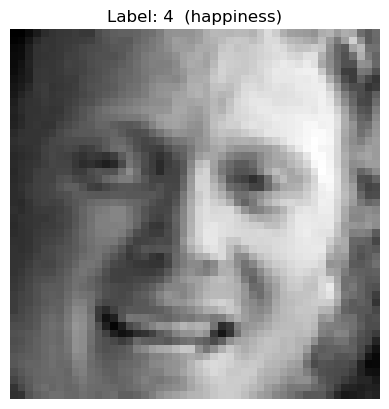

In [2]:
# Shape
print("Shape of feature vectors: ", X.shape)
print("Shape of labels: ", Y.shape)

print("Number of features: ", X.shape[1] * X.shape[2])
print("Number of examples: ", X.shape[0])

# Example Image and Label (after scaling and normalization)
plt.imshow(X[5], cmap="gray")
plt.title(f"Label: {Y[5]}  ({list(class_idx.keys())[list(class_idx.values()).index(Y[5])]})")
plt.axis("off")
plt.show()

#### **Class distribution** 

There is a significant imbalance regarding the number of samples for neutral and happy faces. This suggests that models may become biased toward predicting these majority classes, so stratified sampling and evaluation metrics beyond accuracy (like confusion matrices) are necessary.

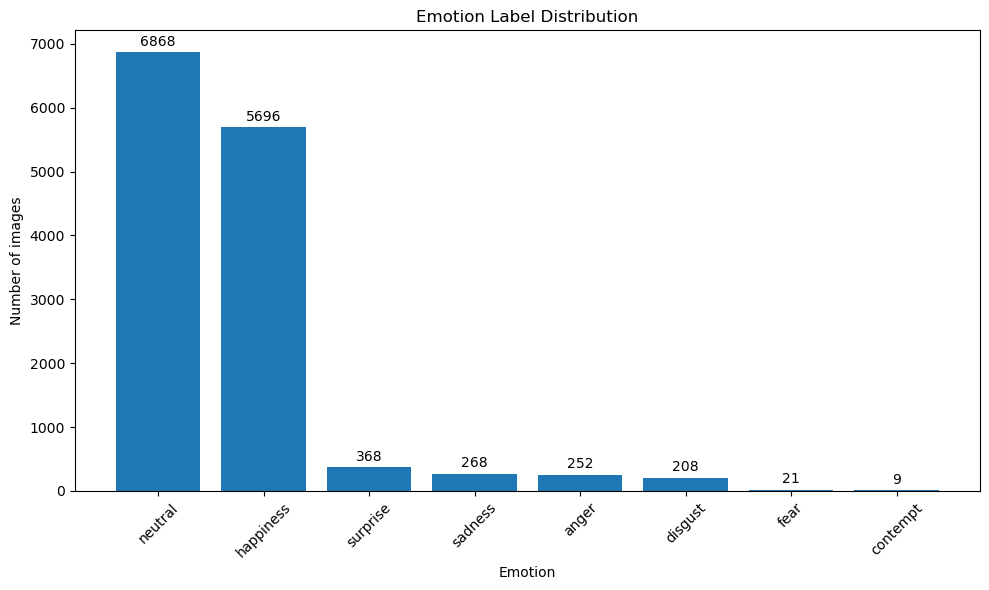

In [3]:
# Visualizing Class Distribution
counts = Counter(Y)
emotions = [c for c in classes]
values = [counts[class_idx[c]] for c in classes]

# Sort by count (descending)
sorted_pairs = sorted(zip(emotions, values), key=lambda x: x[1], reverse=True)
emotions_sorted, values_sorted = zip(*sorted_pairs)

plt.figure(figsize=(10, 6))
bars = plt.bar(emotions_sorted, values_sorted)

# Add count labels on top of each bar
for bar, val in zip(bars, values_sorted):
  plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
           str(val), ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.xlabel("Emotion")
plt.ylabel("Number of images")
plt.title("Emotion Label Distribution")
plt.tight_layout()
plt.show()

#### **Pixel Intensity** 

Histograms of pixel intensities at fixed image locations show significant variability across samples, even after normalization. This suggests that individual pixel features are noisy and insufficient on their own, motivating dimensionality reduction techniques such as PCA and models that can aggregate information across many pixels.

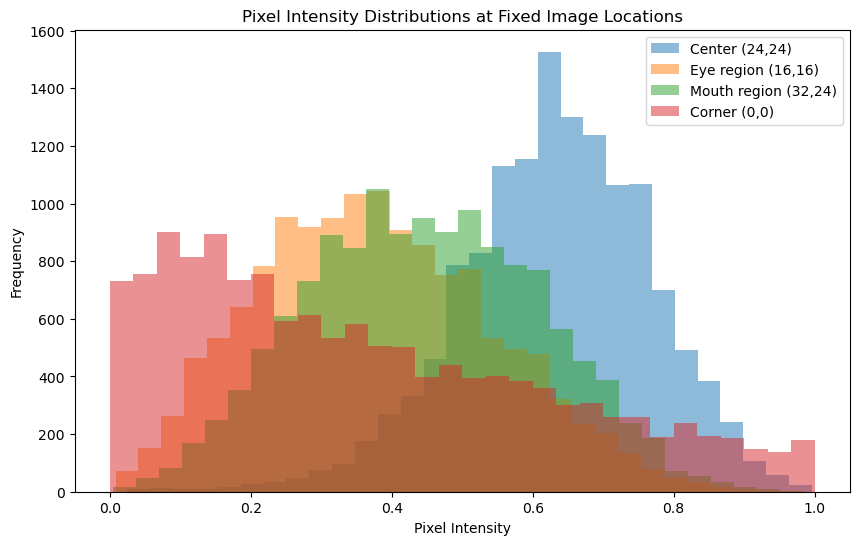

In [4]:
# Visualizing Pixel Distribution
pixel_locations = {
    "Center (24,24)": (24, 24),
    "Eye region (16,16)": (16, 16),
    "Mouth region (32,24)": (32, 24),
    "Corner (0,0)": (0, 0)
}

plt.figure(figsize=(10, 6))

for label, (r, c) in pixel_locations.items():
    values = X[:, r, c]
    plt.hist(values, bins=30, alpha=0.5, label=label)

plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distributions at Fixed Image Locations")
plt.legend()
plt.show()


#### **PCA Visualization**

Principle Component Analysis reduces each image to lower dimensions. Using PCA 2 allows us to visualize the 2 most important directions of variation in the images. This scatterplot shows that the data is not linearly separable by 2 dimensions, images are noisy, emotions visually overlap, and some expressions are subtle. Ultimately, this suggests that simple linear models (such as logistic regression or linear SVMs) are unlikely to perform well. The high overlap in PCA space also indicates that more complex nonlinear methods, such as SVMs with RBF kernels or convolutional neural networks, may be required to capture the structure of the data.

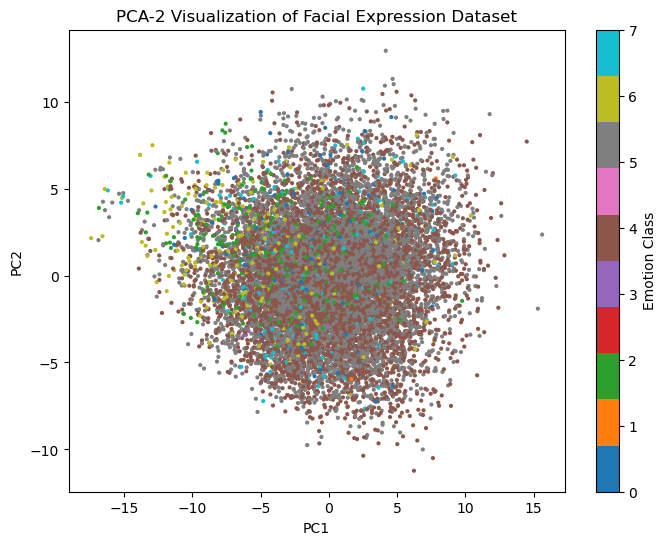

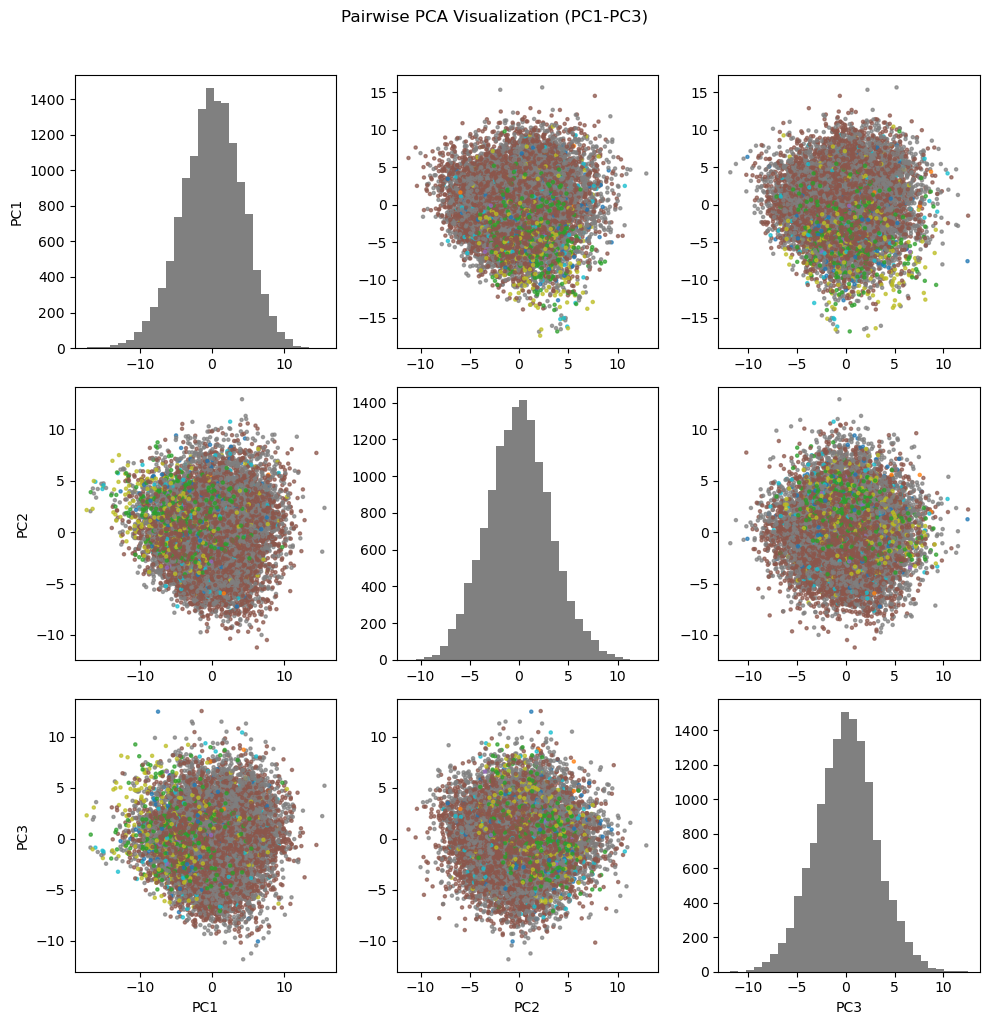

In [5]:
# PCA Visualization

# PCA with 2 components
X_flat = X.reshape(X.shape[0], -1)
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_flat)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=Y, cmap="tab10", s=4)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA-2 Visualization of Facial Expression Dataset")
plt.colorbar(label="Emotion Class")
plt.show()

# PCA with 3 components
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_flat)

pcs = ["PC1", "PC2", "PC3"]
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]

        if i == j:
            ax.hist(X_pca3[:, i], bins=30, color="gray")
        else:
            ax.scatter(
                X_pca3[:, j],
                X_pca3[:, i],
                c=Y,
                cmap="tab10",
                s=5,
                alpha=0.7
            )

        if i == 2:
            ax.set_xlabel(pcs[j])
        if j == 0:
            ax.set_ylabel(pcs[i])

plt.suptitle("Pairwise PCA Visualization (PC1-PC3)", y=1.02)
plt.tight_layout()
plt.show()


## **2: Model Tuning**
---

We trained multiple classifiers to predict emotions and compared their performance.

In [6]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

#### **Train and Test Splits**

We flatten the image data, create a stratified train–test split, use a representative subset of the training data for efficient hyperparameter tuning, and apply feature standardization.

In [7]:
# Train and test split for tuning
X_flat = X.reshape(X.shape[0], -1)

# Hold-out test set (never used for tuning)
X_train_pool, X_test, y_train_pool, y_test = train_test_split(
    X_flat, Y,
    test_size=0.20,
    stratify=Y,
    random_state=42
)

# Validation / tuning subset
X_val, _, y_val, _ = train_test_split(
    X_train_pool,
    y_train_pool,
    train_size=0.35,     
    stratify=y_train_pool,
    random_state=42
)

# 3) Standardize (fit ONLY on validation / training data)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)


#### **Baseline Model - Linear Regression Tuning: Regularization (C)**

We tune the regularization strength of Logistic Regression by evaluating accuracy across multiple values of C, allowing us to study the bias–variance tradeoff and select a well-generalizing model. `C = 0.01` achieves the highest accuracy.

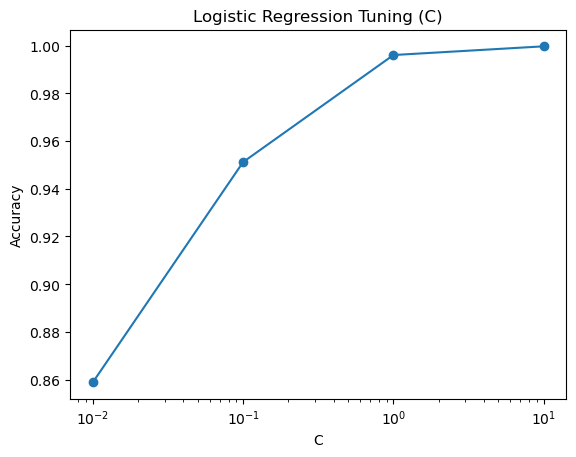

In [8]:
from sklearn.linear_model import LogisticRegression

Cs = [0.01, 0.1, 1, 10]
accs = []
for C in Cs:
    lr = LogisticRegression(max_iter=2000, C=C)
    lr.fit(X_val, y_val)
    accs.append(lr.score(X_val, y_val))

plt.plot(Cs, accs, marker='o')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Tuning (C)")
plt.show()

#### **Decision Tree Tuning: max_depth and min_samples_leaf**

We tune min_samples_leaf and max_depth to control decision tree complexity. Larger leaf sizes and moderate depths improve accuracy, indicating that regularization is necessary to prevent overfitting. Accuracy peaks with `min_samples_leaf = 25` and `max_depth = 5`.

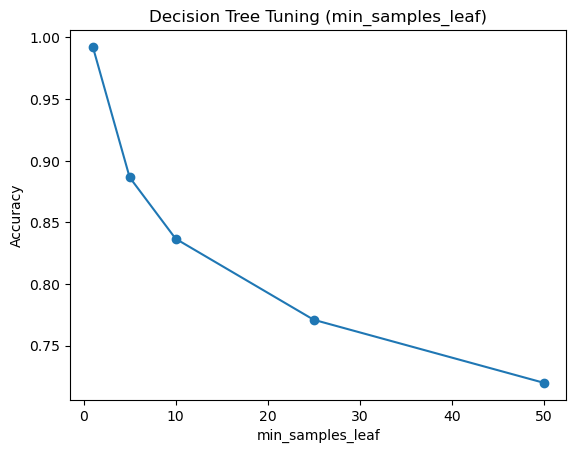

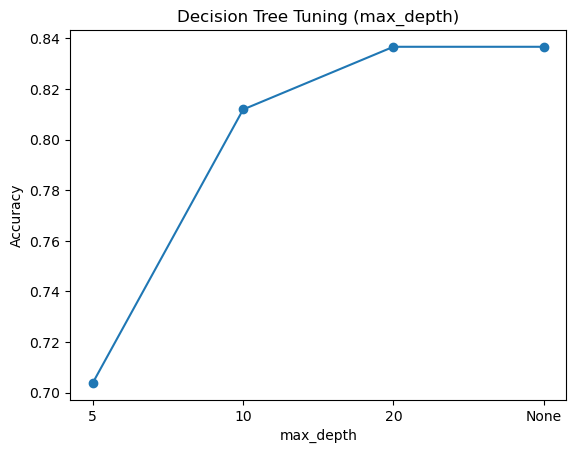

In [9]:
leaf_sizes = [1, 5, 10, 25, 50]
accs = []

for leaf in leaf_sizes:
    dt = DecisionTreeClassifier(
        max_depth=20,          
        min_samples_leaf=leaf,
        random_state=42
    )
    dt.fit(X_val, y_val)
    accs.append(dt.score(X_val, y_val))

plt.plot(leaf_sizes, accs, marker='o')
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title("Decision Tree Tuning (min_samples_leaf)")
plt.show()

depths = [5, 10, 20, None]
accs = []

for d in depths:
    dt = DecisionTreeClassifier(
        max_depth=d,
        min_samples_leaf=10,
        random_state=42
    )
    dt.fit(X_val, y_val)
    accs.append(dt.score(X_val, y_val))

plt.plot([str(d) for d in depths], accs, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Tuning (max_depth)")
plt.show()




#### **SVM Tuning: PCA and Regularization (C)**
While dimensionality reduction helps remove noise, overly aggressive compression (e.g., 10 components) leads to information loss. Performance improves as more components are retained, plateauing around 50–100 components. Based on hyperparameter tuning, we use PCA with `100 components` followed by a linear SVM with `C = 0.1`.

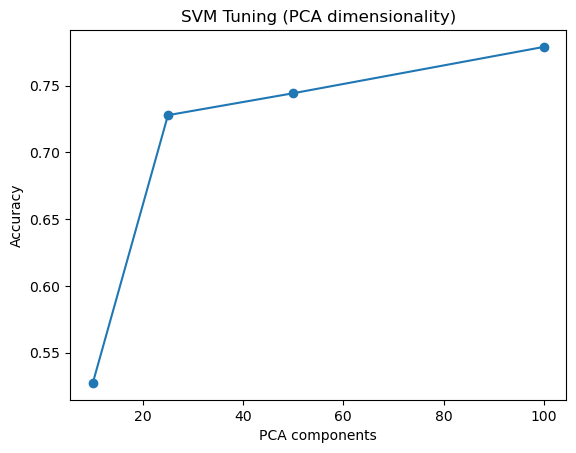

In [12]:
# PCA Hyperparameter Tuning
components = [10, 25, 50, 100]
accs = []

for k in components:
    pca = PCA(n_components=k)
    X_val_k = pca.fit_transform(X_val)

    svm = LinearSVC(C=1)
    svm.fit(X_val_k, y_val)
    accs.append(svm.score(X_val_k, y_val))

plt.plot(components, accs, marker='o')
plt.xlabel("PCA components")
plt.ylabel("Accuracy")
plt.title("SVM Tuning (PCA dimensionality)")
plt.show()


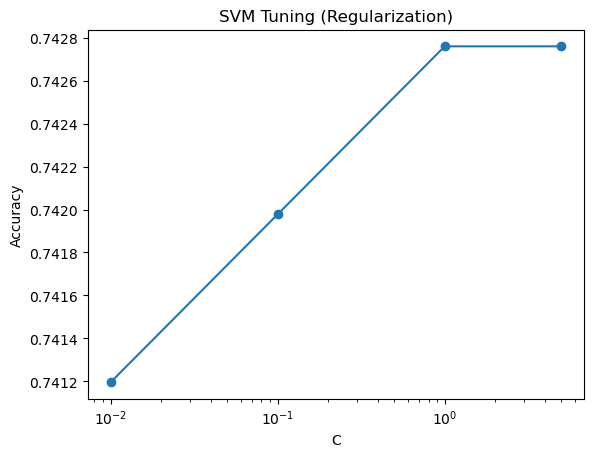

In [13]:
# SVM Regularization Tuning (C)
Cs = [0.01, 0.1, 1, 5]
accs = []

pca = PCA(n_components=50)
X_val_pca = pca.fit_transform(X_val)

for C in Cs:
    svm = LinearSVC(C=C)
    svm.fit(X_val_pca, y_val)
    accs.append(svm.score(X_val_pca, y_val))

plt.plot(Cs, accs, marker='o')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("SVM Tuning (Regularization)")
plt.show()

#### **SVM Cross-validation**

Cross-validation confirms that the PCA + linear SVM pipeline generalizes consistently across folds, with low variance in accuracy.

In [14]:
# Cross-validation for SVM C
pipeline = Pipeline([
    ("pca", PCA(n_components=50)),
    ("svm", LinearSVC(C=1, max_iter=5000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipeline,
    X_val,     
    y_val,
    cv=cv,
    scoring="accuracy"
)

print("Cross-validation accuracies:", scores)
print("Mean CV accuracy:", scores.mean())
print("Std CV accuracy:", scores.std())


c:\Users\laure\miniconda3\envs\cs178\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation accuracies: [0.74185137 0.72881356 0.726206   0.72454308 0.74281984]
Mean CV accuracy: 0.7328467699932939
Std CV accuracy: 0.007872266455102183


## **3: Model Testing & Evaluation**
---

Each model is retrained using the chosen configuration and evaluated on held-out data to assess generalization performance. This evaluation reflects how well the models perform on unseen examples and allows for a fair comparison between classifiers under their optimal settings.

Final performance is reported using a fixed test set, with all models trained on a stratified 35% subset of the data due to computational constraints.

Training LR
LR Done
Training SVM
SVM Done
Training DT
DT Done

=== Performance Comparison (Accuracy & F1) ===
Baseline                  0.5018     0.0835
Logistic Regression       0.7571     0.2840
PCA + Linear SVM          0.7385     0.2019
Decision Tree             0.6392     0.1652


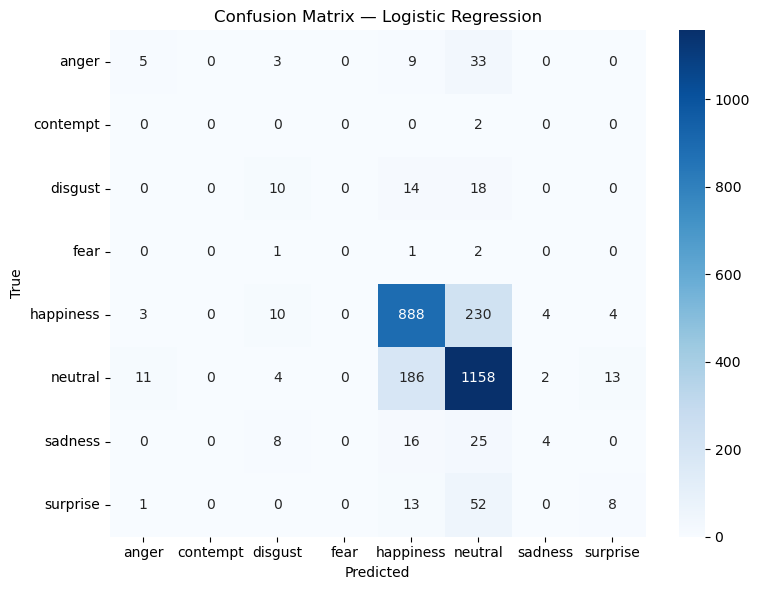

In [17]:
from model import run_models

classes = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

accuracies = run_models(
    X_val,     # 35% training data
    y_val,
    X_test,    # fixed hold-out test set
    y_test,
    class_names=classes
)

#### **Evaluation of Results**

We expected PCA + Linear SVM to perform competitively, as dimensionality reduction can improve generalization in high-dimensional settings. However, due to computational constraints, PCA dimensionality was limited, which may have restricted the model’s ability to retain discriminative features. With additional computational resources (better GPU and memory resources), exploring higher-dimensional PCA representations or alternative feature learning approaches may further improve performance.

Logistic Regression achieves the best overall performance with a test accuracy of 75.7% and a macro F1-score of 0.284, outperforming PCA + Linear SVM and Decision Tree models. While accuracy is relatively high, the lower macro F1-score reflects significant class imbalance in the dataset, with strong performance on majority classes such as happiness and neutral and weaker performance on underrepresented emotions. The confusion matrix shows that most errors occur between visually similar classes, particularly happiness and neutral. These results suggest that a simple linear model with appropriate regularization generalizes better than more complex pipelines for this high-dimensional image classification task.
